In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Preparing data
### Loading the review spreasheet as a multi-index (tsv)

In [2]:
base = pd.read_csv("../data/InterfaceReview-May2019.tsv", sep="\t", index_col= [0,1], skipinitialspace=True)

In [3]:
base.head()

Austrian Newspapers Online (ANNO)  \
interface URL                                                      http://anno.onb.ac.at/   
          Target area                                      Austria (and former AH empire)   
          Creator                                             National library of Austria   
          Purpose and scope             Collection of historical newspaper and journal...   
          Approximate date of creation                                               2003   

                                                                                 Ancestry  \
interface URL                                                 https://www.newspapers.com/   
          Target area                                                    US, UK, AUS, CAN   
          Creator                                                            Ancestry.com   
          Purpose and scope             Collection of EN-speaking newspapers, primary ...   
          Approximate date of creation                                                  u   

                                                        British Newspaper Archives  \
interface URL                           https://www.britishnewspaperarchive.co.uk/   
          Target area                                                British isles   
          Creator                                                  British Library   
          Purpose and scope                       collection of British newspapers   
          Approximate date of creation                                           u   

                                           California Digital Newspaper Collection (CDNC)  \
interface URL                                           https://cdnc.ucr.edu/cgi-bin/cdnc   
          Target area                                                      California, US   
          Creator                       California State Library, National Endowment f...   
          Purpose and scope             To digitize California newspapers for the Nati...   
          Approximate date of creation                                               2008   

                                                                      Chronicling America  \
interface URL                                           http://chroniclingamerica.loc.gov   
          Target area                                                       United States   
          Creator                                                     Library of Congress   
          Purpose and scope             Collection of selected American newspapers dig...   
          Approximate date of creation                                                  u   

                                          Colorado Historical Newspaper Collection (CHNC)  \
interface URL                                 https://www.coloradohistoricnewspapers.org/   
          Target area                                                        Colorado, US   
          Creator                       Colorado State Library, History Colorado, Coll...   
          Purpose and scope             The long-term goal for CHNC is to provide acce...   
          Approximate date of creation                                            ca 2005   

                                                                                  Delpher  \
interface URL                                         https://www.delpher.nl/nl/kranten/    
          Target area                                  Netherland and its former colonies   
          Creator                                                     Royal Dutch Library   
          Purpose and scope             Access to digitized texts incl. books, journal...   
          Approximate date of creation                                            ongoing   

                                                                                DigiPress  \
interface URL                                   https://digipress.digitale-sammlungen.de/   

### Testing some indexing

In [ ]:
base.loc['apis','IIIF Image API']

In [ ]:
base.loc['information on digitization','OCR confidence scores'].describe()

In [ ]:
base.loc['newspaper metadata','Place of publication']

In [ ]:
# counts will not work for categorical data
base.loc['newspaper collection', 'Languages of the collections']

### Do some cleaning
#### Trim string to be sure

In [4]:
def trim_all_columns(df):
    """
    Trim whitespace from ends of each value across all series in dataframe
    """
    trim_strings = lambda x: x.strip() if type(x) is str else x
    return df.applymap(trim_strings)

# trim
base = trim_all_columns(base)

#### Remove undesirable rows (i.e. not entirely binary)

In [5]:
base = base.drop('interface', level=0)
base = base.drop('newspaper collection', level=0)
base = base.drop('Other', level=1)
base = base.drop('Languages of the collections', level=1)
base = base.drop('Download options (file formats)', level=1)

#### Replace n and y by 0 and 1 (ideally to clean in spreadsheet)

In [6]:
base = base.replace(to_replace=['y', 'y?', 'y (annotations)', 'y (requires user account - free)', 'n', '?', 'u', 'n?'], value=[1,1,1,1,0,0,0,0])

In [7]:
base.head()

Austrian Newspapers Online (ANNO)  \
newspaper metadata Alternative titles, succeeding titles, related ...                                 1   
                   Place of publication                                                               1   
                   Geographic coverage                                                                0   
                   Publisher                                                                          1   
                   Date range                                                                         1   

                                                                      Ancestry  \
newspaper metadata Alternative titles, succeeding titles, related ...        0   
                   Place of publication                                      1   
                   Geographic coverage                                       1   
                   Publisher                                                 0   
                   Date range                                                1   

                                                                      British Newspaper Archives  \
newspaper metadata Alternative titles, succeeding titles, related ...                          1   
                   Place of publication                                                        1   
                   Geographic coverage                                                         1   
                   Publisher                                                                   1   
                   Date range                                                                  1   

                                                                      California Digital Newspaper Collection (CDNC)  \
newspaper metadata Alternative titles, succeeding titles, related ...                                              1   
                   Place of publication                                                                            1   
                   Geographic coverage                                                                             0   
                   Publisher                                                                                       0   
                   Date range                                                                                      1   

                                                                      Chronicling America  \
newspaper metadata Alternative titles, succeeding titles, related ...                   1   
                   Place of publication                                                 1   
                   Geographic coverage                                                  1   
                   Publisher                                                            1   
                   Date range                                                           1   

                                                                      Colorado Historical Newspaper Collection (CHNC)  \
newspaper metadata Alternative titles, succeeding titles, related ...                                               0   
                   Place of publication                                                                             1   
                   Geographic coverage                                                                              0   
                   Publisher                                                                                        0   
                   Date range                                                                                       1   

                                                                      Delpher  \
newspaper metadata Alternative titles, succeeding titles, related ...       0   
                   Place of publication                                     1   
                   Geographic coverage                                      1   
  

## Radar factory

In [8]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle' | 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels, fontsize):
            self.set_thetagrids(np.degrees(theta), labels, fontsize=fontsize)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

In [56]:
def build_single_radar(labels, values, title, grid, figure_title):
    N = len(labels)
    theta = radar_factory(N, frame='polygon')
    
    fig, ax = plt.subplots(figsize=(5,5), subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(top=0.85, bottom=0.05)

    #ax.set_rgrids([2, 4, 6, 8])
    ax.set_rgrids(grid, labels=[str(i) for i in grid], size='large')
    ax.set_title(title,  position=(0.5, 1.1), ha='center')

    for d in values:
        line = ax.plot(theta, d)
        ax.fill(theta, d,  alpha=0.25)
    ax.set_varlabels(labels, fontsize=12)
    
    if figure_title is None:
        plt.show()
    else:
        plt.savefig(f'../charts/{figure_title}.pdf', format='pdf', quality=95)

In [121]:
def build_multiple_radar(labels, values, titles, grid, figure_title):
    N = len(labels)
    theta = radar_factory(N, frame='polygon')
        
    fig, axes = plt.subplots(figsize=(120, 80), nrows=4, ncols=6,
                             subplot_kw=dict(projection='radar'))
    
    fig.subplots_adjust(wspace=0.45, hspace=0.20, top=0.85, bottom=0.05)

    for ax, case_data, title in zip(axes.flatten(), values, titles):
        #ax.set_rgrids(['2', '4', '6', '8'])
        #ax.set_rgrids(grid, labels=[str(i) for i in grid], size='large')
        ax.set_ylim(0, 30)
        ax.set_title(title, weight='bold', fontsize=42, position=(0.5, 1.1),
                     horizontalalignment='center', verticalalignment='center')
        line = ax.plot(theta, case_data)
        ax.fill(theta, case_data,  alpha=0.25)
        ax.set_varlabels(labels, fontsize=32)

    if figure_title is None:
        plt.show()
    else:
        plt.savefig(f'../charts/{figure_title}.pdf', format='pdf', quality=95)

## Interface charts
### Counts

#### Sum values of level 1 => 'grade' of each interface per family of features

In [122]:
level_0 = base.groupby(level=0).sum(axis=1)

In [123]:
level_0 = level_0.reindex(["newspaper metadata", 
                 "browsing",
                 "search",
                 "result sorting",
                 "result filtering",
                 "result display",
                 "viewer",
                 "user interaction",
                 "enrichment",
                 "information on digitization",
                 "connectivity",
                 "apis"
                    ])

In [124]:
level_0 = level_0.reindex(["newspaper metadata", 
                 "apis",
                 "connectivity",
                 "information on digitization",
                 "enrichment",
                 "user interaction",
                 "viewer",
                 "result display",
                 "result filtering",
                 "result sorting",
                 "search",
                 "browsing"
                    ])

In [125]:
level_0.head()

Austrian Newspapers Online (ANNO)  Ancestry  \
newspaper metadata                                           9         3   
apis                                                         0         0   
connectivity                                                 0         0   
information on digitization                                  2         0   
enrichment                                                   1         0   

                             British Newspaper Archives  \
newspaper metadata                                    5   
apis                                                  0   
connectivity                                          0   
information on digitization                           3   
enrichment                                            0   

                             California Digital Newspaper Collection (CDNC)  \
newspaper metadata                                                        6   
apis                                                                      0   
connectivity                                                              0   
information on digitization                                               2   
enrichment                                                                1   

                             Chronicling America  \
newspaper metadata                            12   
apis                                           1   
connectivity                                   2   
information on digitization                    3   
enrichment                                     0   

                             Colorado Historical Newspaper Collection (CHNC)  \
newspaper metadata                                                         2   
apis                                                                       0   
connectivity                                                               0   
information on digitization                                                1   
enrichment                                                                 1   

                             Delpher  DigiPress  DIFMOE  E-luxemburgensia  \
newspaper metadata                 6          7       9                 6   
apis                               1          1       0                 0   
connectivity                       1          0       0                 0   
information on digitization        1          1       1                 3   
enrichment                         1          0       0                 0   

                             ...  Georgia Historic Newspapers  \
newspaper metadata           ...                           10   
apis                         ...                            2   
connectivity                 ...                            0   
information on digitization  ...                            1   
enrichment                   ...                            0   

                             Libraria - Ukrainian online periodicals archive  \
newspaper metadata                                                         4   
apis                                                                       0   
connectivity                                                               0   
information on digitization                                                4   
enrichment                                                                 0   

                             New York Times  POLONA  Retronews  Scriptorium  \
newspaper metadata                        1       7          7            3   
apis                                      0       0          0            0   
connectivity                              0       0          3            0   
information on digitization               0       1          2            1   
enrichment                                0       0          5            0   

                             StaBi  Tessmann  Le Temps archives  Trove  
newspaper metadata               7         8                  0  

#### Observations per feature family

In [126]:
#Total sum per row, ie. per feature family (=> how good are all interfaces for a certain aspect): 
level_0.loc[:,'Total'] = level_0.sum(axis=1)

In [127]:
level_0['Total (%)'] = level_0['Total']/level_0['Total'].sum() * 100

#### Radar/Star/Spider with just one interface

In [128]:
# getting the labels
labels = level_0.index
labels

Index(['newspaper metadata', 'apis', 'connectivity',
       'information on digitization', 'enrichment', 'user interaction',
       'viewer', 'result display', 'result filtering', 'result sorting',
       'search', 'browsing'],
      dtype='object')

In [129]:
# Get all rows, just for the first columns, and transpose it (for the radar factory)
level_0.iloc[:12, :1].T

newspaper metadata  apis  connectivity  \
Austrian Newspapers Online (ANNO)                   9     0             0   

                                   information on digitization  enrichment  \
Austrian Newspapers Online (ANNO)                            2           1   

                                   user interaction  viewer  result display  \
Austrian Newspapers Online (ANNO)                 0       5               2   

                                   result filtering  result sorting  search  \
Austrian Newspapers Online (ANNO)                 5               4       9   

                                   browsing  
Austrian Newspapers Online (ANNO)         3

In [130]:
# take only the values
first_interface = level_0.iloc[:12, :1].T.values

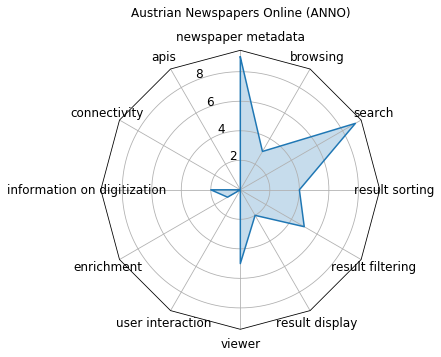

In [131]:
build_single_radar(labels, values=first_interface, title=level_0.columns[0], grid=[2,4,6,8], figure_title='Anno')

#### Radar view for each interface in one figure

In [132]:
# take the data: all rows and up to the 23th columns (selecting precisely in case Total columns are added)
all_interfaces_counts = level_0.iloc[:12, :23].T.values

# same with percentages
level_0_percent = base.groupby(level=0).sum(axis=1).apply(lambda x: 100*x/float(x.sum()))

In [133]:
level_0_percent.head()

Austrian Newspapers Online (ANNO)  Ancestry  \
apis                                                       0.0  0.000000   
browsing                                                   7.5  9.677419   
connectivity                                               0.0  0.000000   
enrichment                                                 2.5  0.000000   
information on digitization                                5.0  0.000000   

                             British Newspaper Archives  \
apis                                           0.000000   
browsing                                       5.882353   
connectivity                                   0.000000   
enrichment                                     0.000000   
information on digitization                    8.823529   

                             California Digital Newspaper Collection (CDNC)  \
apis                                                               0.000000   
browsing                                                           8.333333   
connectivity                                                       0.000000   
enrichment                                                         2.083333   
information on digitization                                        4.166667   

                             Chronicling America  \
apis                                    2.631579   
browsing                                2.631579   
connectivity                            5.263158   
enrichment                              0.000000   
information on digitization             7.894737   

                             Colorado Historical Newspaper Collection (CHNC)  \
apis                                                                     0.0   
browsing                                                                 7.5   
connectivity                                                             0.0   
enrichment                                                               2.5   
information on digitization                                              2.5   

                              Delpher  DigiPress  DIFMOE  E-luxemburgensia  \
apis                         1.960784        2.5     0.0          0.000000   
browsing                     0.000000        5.0     7.5          6.896552   
connectivity                 1.960784        0.0     0.0          0.000000   
enrichment                   1.960784        0.0     0.0          0.000000   
information on digitization  1.960784        2.5     2.5         10.344828   

                             ...  Georgia Historic Newspapers  \
apis                         ...                     6.060606   
browsing                     ...                    12.121212   
connectivity                 ...                     0.000000   
enrichment                   ...                     0.000000   
information on digitization  ...                     3.030303   

                             Libraria - Ukrainian online periodicals archive  \
apis                                                                0.000000   
browsing                                                           11.538462   
connectivity                                                        0.000000   
enrichment                                                          0.000000   
information on digitization                                        15.384615   

                             New York Times    POLONA  Retronews  Scriptorium  \
apis                                    0.0  0.000000   0.000000          0.0   
browsing                                0.0  5.405405   4.918033          0.0   
connectivity                            0.0  0.000000   4.918033          0.0   
enrichment                              0.0  0.000000   8.196721          0.0   
information on digitization             0.0  2.702703   3.278689          4.0   

                                StaBi  Tessmann  Le Temps archives      Trove  
apis                         4.545455  0

In [134]:
# checking we have 100 everywhere
level_0_percent.sum()

Austrian Newspapers Online (ANNO)                  100.0
Ancestry                                           100.0
British Newspaper Archives                         100.0
California Digital Newspaper Collection (CDNC)     100.0
Chronicling America                                100.0
Colorado Historical Newspaper Collection (CHNC)    100.0
Delpher                                            100.0
DigiPress                                          100.0
DIFMOE                                             100.0
E-luxemburgensia                                   100.0
E-newspaperarchives                                100.0
The European Library (TEL)                         100.0
L'Express                                          100.0
Georgia Historic Newspapers                        100.0
Libraria - Ukrainian online periodicals archive    100.0
New York Times                                     100.0
POLONA                                             100.0
Retronews                      

In [135]:
level_0_percent.max().max()

31.818181818181817

In [136]:
all_interfaces_percents = level_0_percent.iloc[:12, :23].T.values

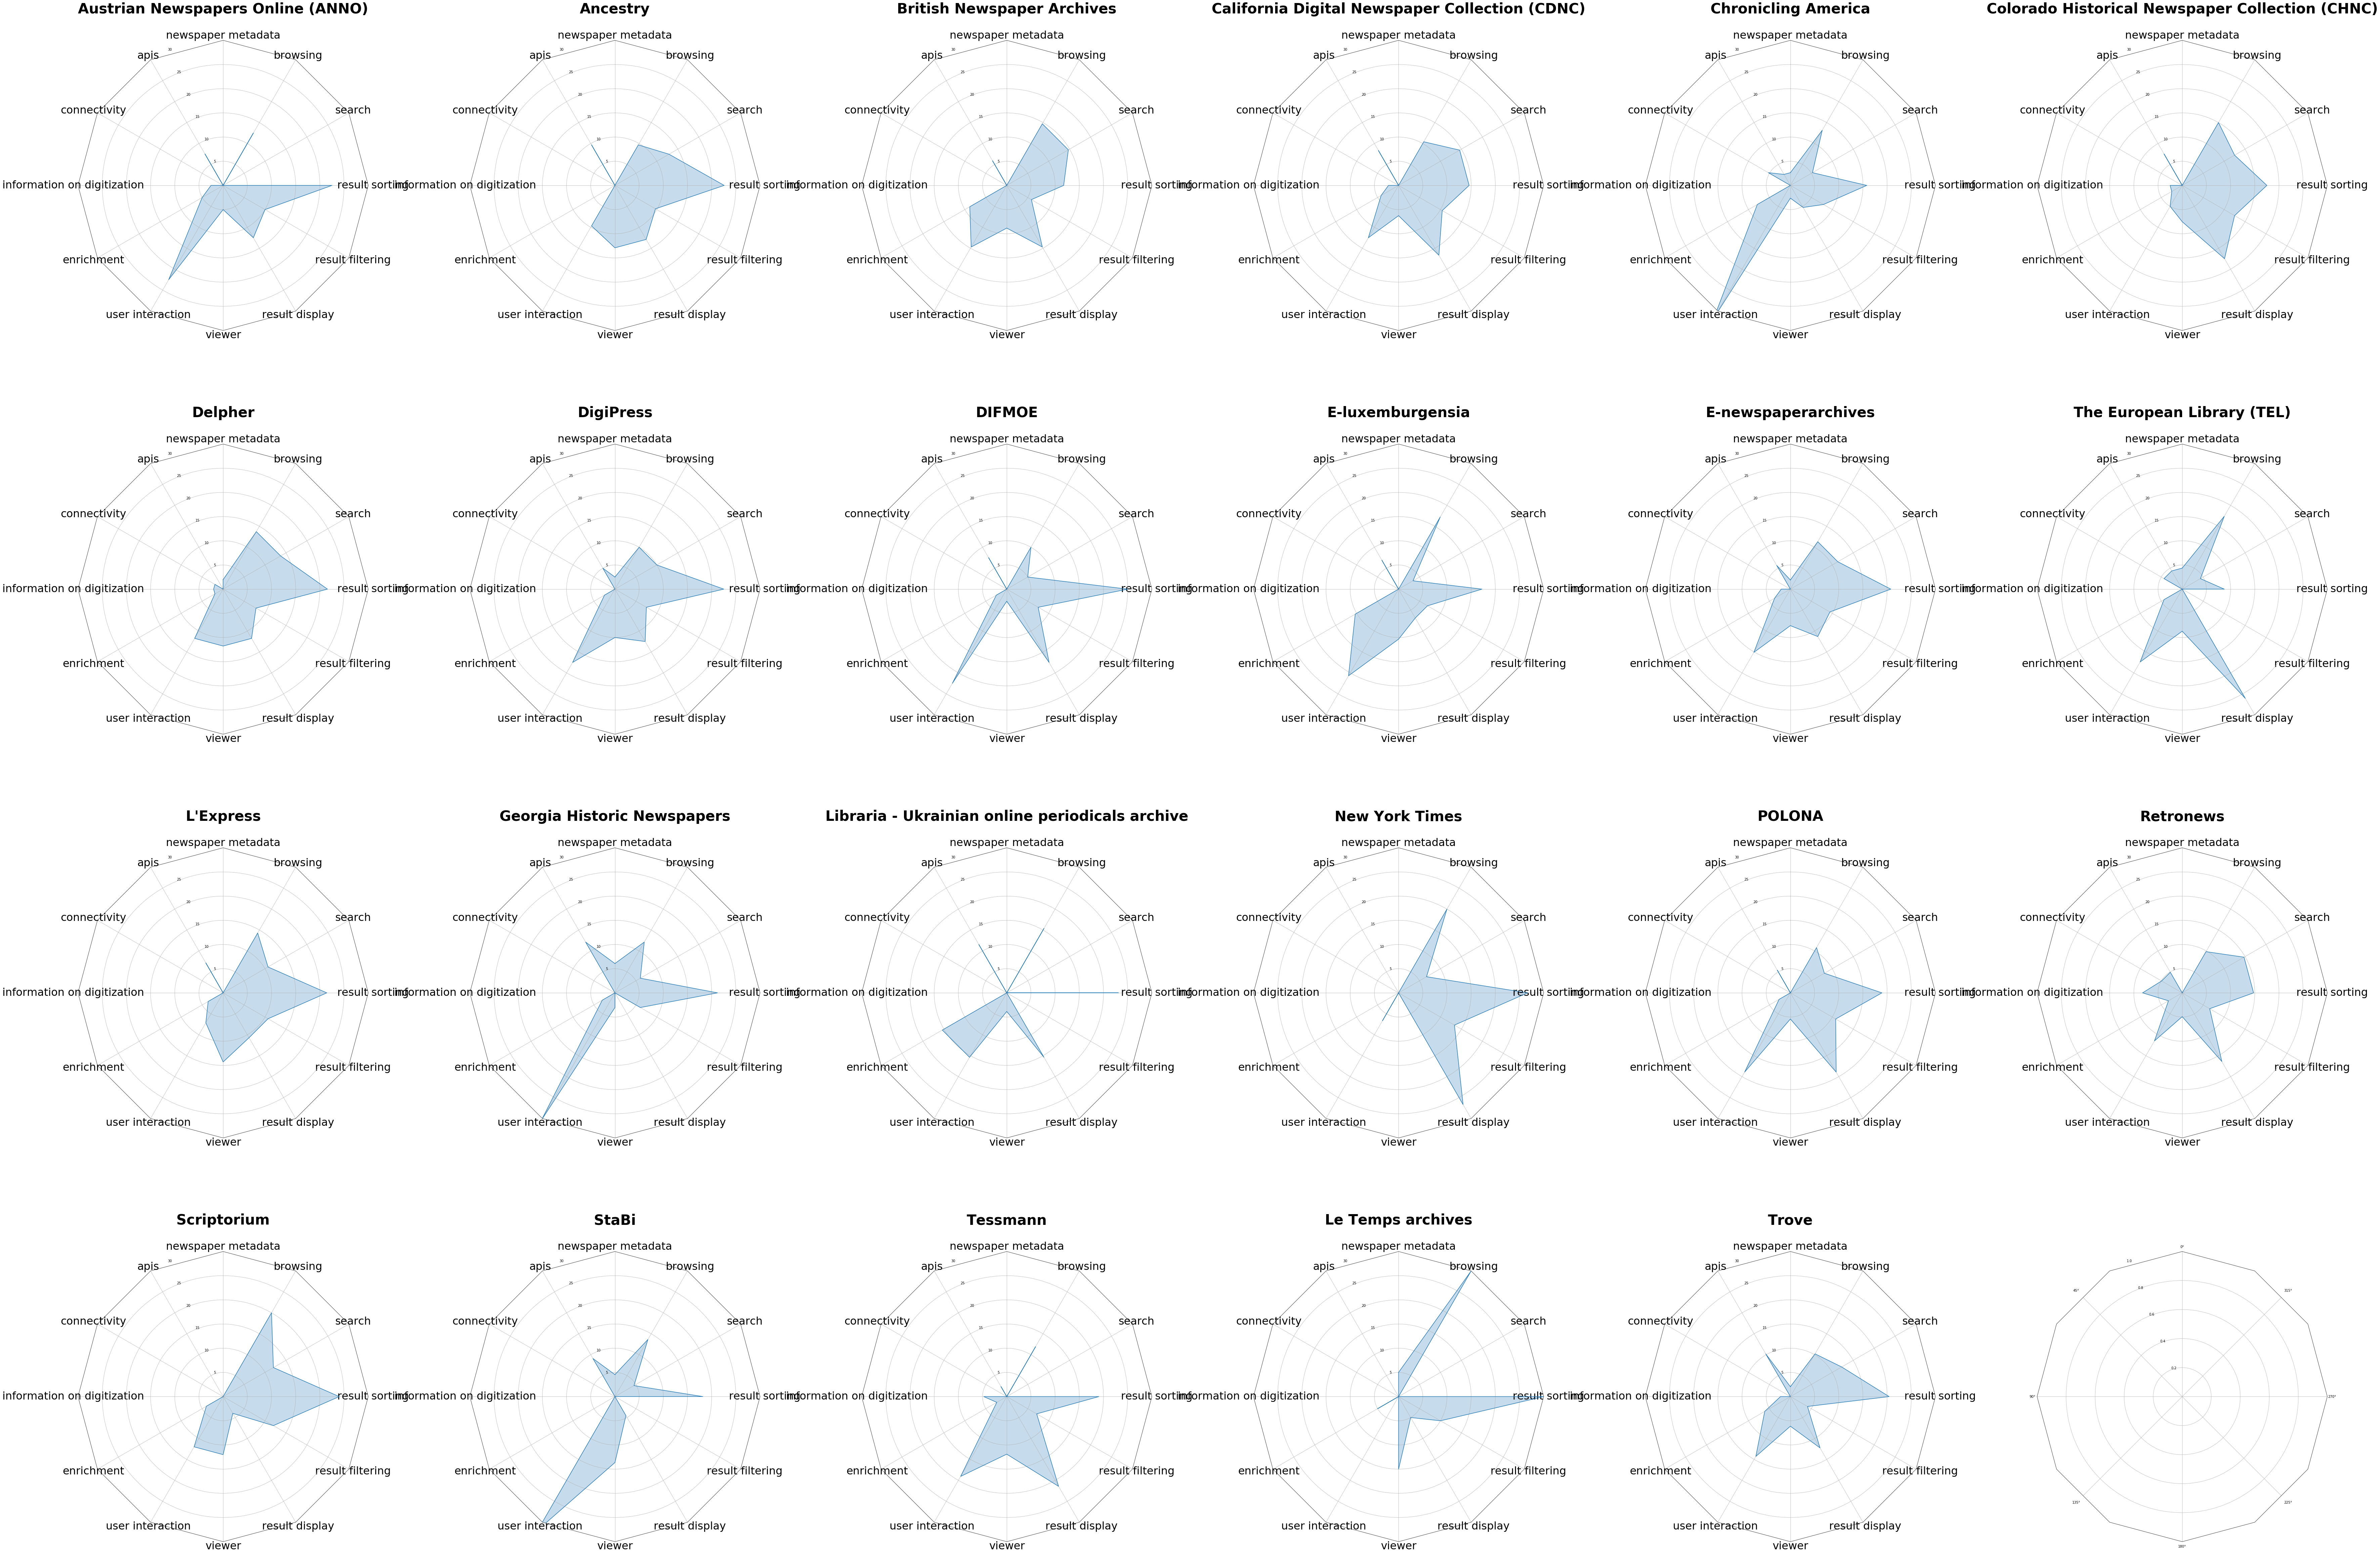

In [120]:
build_multiple_radar(labels, all_interfaces_percents, level_0.columns[:23], [10, 20, 30], 'all-interfaces-single')

#### Global radar view (i.e. for all interfaces) over all features

In [ ]:
# take only the last column: Total per feature family, in percent
values = level_0.iloc[:,24:].T.values

In [ ]:
values

In [ ]:
build_single_radar(labels, values, "All interfaces",grid=[5,10,15,20],figure_title='all-interfaces-global')

#### Global radar view focusing on Search (where there are a lot of features)

In [ ]:
search = base.loc['search'].copy()
search.loc[:,'Total'] = search.sum(axis=1)
search['Total (%)'] = search['Total']/search['Total'].sum() * 100

In [ ]:
search.head()

In [ ]:
labels_search = search.index

In [ ]:
labels_search

In [ ]:
values = search.iloc[:,25:].T.values

In [ ]:
values

In [ ]:
build_single_radar(labels_search, values, title=search.iloc[:,25:].index, grid=[2,4,6,8], figure_title="Search")

In [ ]:
build_single_radar(labels, values=first_interface, title="Search", grid=[2,4,6,8], figure_title=None)

In [ ]:
search.iloc[:,25:].index

In [ ]:
level_0.loc['result filtering']['Retronews']